In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
import numpy as np

IBMQ.save_account('03927d9258ef7fd9fbacf9dbee829b761fbf0f8beea3966880e3a8870bfec3badb1ff3d4425e42361746c5ed0ca9e207cb34890dcddbf7929846390b60ba5c45')
IBMQ.load_account()

configrc.store_credentials:WARNING:2024-05-18 00:05:39,801: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider('ibm-q')
backends = provider.backends()
for backend in backends:
    print(backend)

ibm_sherbrooke
ibm_brisbane
ibm_kyoto
ibm_osaka


In [3]:
qc = QuantumCircuit(4, 4)
qc.h(range(4))  # Apply Hadamard to all qubits
qc.cz(0, 1)  # Controlled-Z gate
qc.cx(1, 2)  # CNOT gate
qc.t(3)  # T gate on qubit 3
qc.s(2)  # S gate on qubit 2
qc.z(1)  # Pauli-Z on qubit 1
qc.measure(range(4), range(4))
print(qc)

     ┌───┐          ┌─┐           
q_0: ┤ H ├──■───────┤M├───────────
     ├───┤  │       └╥┘┌───┐┌─┐   
q_1: ┤ H ├──■────■───╫─┤ Z ├┤M├───
     ├───┤     ┌─┴─┐ ║ ├───┤└╥┘┌─┐
q_2: ┤ H ├─────┤ X ├─╫─┤ S ├─╫─┤M├
     ├───┤┌───┐└┬─┬┘ ║ └───┘ ║ └╥┘
q_3: ┤ H ├┤ T ├─┤M├──╫───────╫──╫─
     └───┘└───┘ └╥┘  ║       ║  ║ 
c_0: ════════════╬═══╩═══════╬══╬═
                 ║           ║  ║ 
c_1: ════════════╬═══════════╩══╬═
                 ║              ║ 
c_2: ════════════╬══════════════╩═
                 ║                
c_3: ════════════╩════════════════
                                  


In [4]:
noise_model = NoiseModel()

# Define single-qubit and two-qubit errors
single_qubit_error = depolarizing_error(0.02, 1)
two_qubit_error = depolarizing_error(0.02, 2)

# Add errors to the noise model
noise_model.add_all_qubit_quantum_error(single_qubit_error, ['h', 't', 's', 'z'])
noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx', 'cz'])


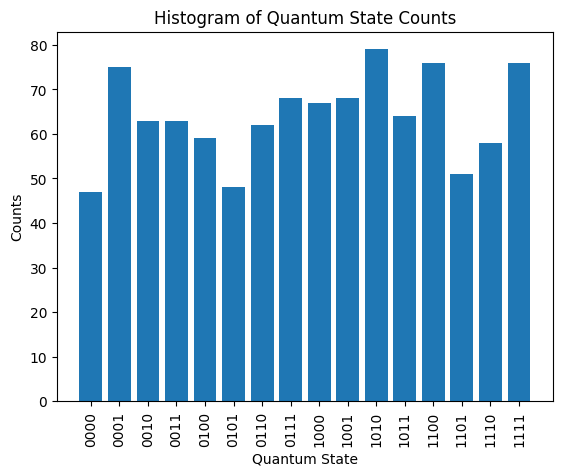

In [5]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, simulator, noise_model=noise_model).result()
counts = result.get_counts(qc)

ordered_counts = dict(sorted(counts.items()))

labels, values = zip(*ordered_counts.items())

plt.bar(labels, values)

plt.xlabel('Quantum State')
plt.ylabel('Counts')
plt.title('Histogram of Quantum State Counts')

plt.xticks(rotation=90)

plt.show()

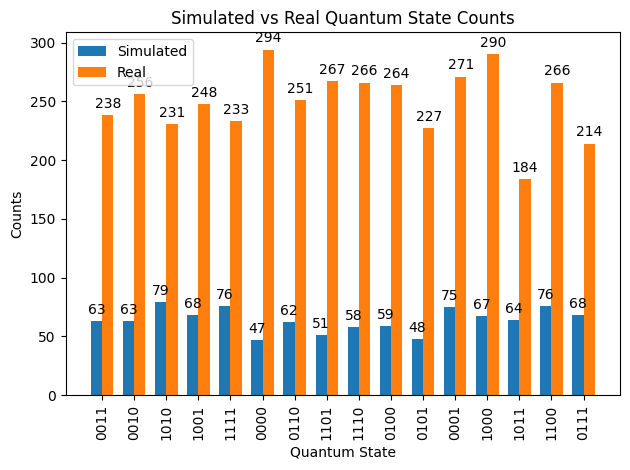

In [6]:
# Execute the circuit on the IBMQ backend with error handling
try:
    job = execute(qc, backend=backend)
    real_counts = job.result().get_counts(qc)
except Exception as e:
    print(f"Error executing job: {e}")
    real_counts = {}

# Ensure both counts are ordered
ordered_simulated_counts = dict(sorted(counts.items()))
ordered_real_counts = dict(sorted(real_counts.items()))

# Combine keys from both dictionaries
all_keys = set(ordered_simulated_counts.keys()).union(set(ordered_real_counts.keys()))

# Create lists for plotting
simulated_values = [ordered_simulated_counts.get(key, 0) for key in all_keys]
real_values = [ordered_real_counts.get(key, 0) for key in all_keys]

# Plotting the histogram
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(all_keys))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, simulated_values, width, label='Simulated')
rects2 = ax.bar(x + width/2, real_values, width, label='Real')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Quantum State')
ax.set_ylabel('Counts')
ax.set_title('Simulated vs Real Quantum State Counts')
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90)
ax.legend()

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()